In [1]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import statsmodels.stats.multitest as sm_multi

In [2]:
# read input files

supp_12_17_excel='../Priya_et_al_Supplementary_Tables/Supplementary Tables S12-S17.xlsx'
supp_1_excel='../Priya_et_al_Supplementary_Tables/Supplementary Table S1.xlsx'

crc_bacteria = pd.read_excel(supp_12_17_excel,engine='openpyxl',sheet_name='S13')
ibd_bacteria = pd.read_excel(supp_12_17_excel,engine='openpyxl',sheet_name='S15')
ibs_bacteria = pd.read_excel(supp_12_17_excel,engine='openpyxl',sheet_name='S17')
crc_metadata = pd.read_excel(supp_1_excel,engine='openpyxl',sheet_name='CRC_metadata',index_col=0)
ibd_metadata = pd.read_excel(supp_1_excel,engine='openpyxl',sheet_name='IBD_metadata',index_col=0)
ibs_metadata = pd.read_excel(supp_1_excel,engine='openpyxl',sheet_name='IBS_metadata',index_col=0)

In [3]:
crc_bacteria.rename(columns={crc_bacteria.columns[0]: 'bacteria'}, inplace=True)
ibd_bacteria.rename(columns={ibd_bacteria.columns[-1]: 'bacteria'}, inplace=True)
ibs_bacteria.rename(columns={ibs_bacteria.columns[0]: 'bacteria'}, inplace=True)
ibs_metadata.set_index('Subject_ID', inplace=True)

In [4]:
EQUAL_VARIANCE = False
ALPHA = 0.05

# perform t-test at ALPHA set above to identify whose abundance is different between 'cases' and 'controls'
def getInterestingBacteria(data, metadata, classificationColumn, classificationValue, alpha=ALPHA):
   
    # identify cases and controls based on nomenclature used for each disease
    patient_ids_1 = metadata.query(f'{classificationColumn} == "{classificationValue}"').index.to_list()
    patient_ids_2 = metadata.query(f'{classificationColumn} != "{classificationValue}"').index.to_list()
    
    data1 = data.filter(items=[*patient_ids_1, 'bacteria'])
    data2 = data.filter(items=[*patient_ids_2, 'bacteria'])
    
    columns = ['statistic', 'p', 'bacteria', 'index']
    summary = pd.DataFrame(columns=columns)
    for i in range(len(data2)):
        result = stats.ttest_ind(data2.loc[i].to_list()[:-1], data1.loc[i].to_list()[:-1], equal_var=EQUAL_VARIANCE)
        summary.loc[i] = [result.statistic, result.pvalue, data2.loc[i]['bacteria'], i]
    
    summary = summary.dropna()
    [result, corrected_p] = sm_multi.fdrcorrection(summary['p'])
    interesting_bacteria = summary[summary['p'] < alpha]
    not_interesting_bacteria = summary[summary['p'] > 1-alpha]
    return [interesting_bacteria, not_interesting_bacteria];

In [5]:
# Extract interesting bacteria for each disease

[crc_interesting_bacteria, crc_not_interesting_bacteria] = getInterestingBacteria(crc_bacteria, crc_metadata, 'Description', 'normal')
[ibd_interesting_bacteria, ibd_not_interesting_bacteria] = getInterestingBacteria(ibd_bacteria, ibd_metadata, 'Diagnosis', 'nonIBD')
[ibs_interesting_bacteria, ibs_not_interesting_bacteria] = getInterestingBacteria(ibs_bacteria, ibs_metadata, 'Cohort', 'Healthy')

# save to excel!
ibs_interesting_bacteria.to_excel('../data/ibs_interesting_bacteria.xlsx')
ibd_interesting_bacteria.to_excel('../data/ibd_interesting_bacteria.xlsx')
crc_interesting_bacteria.to_excel('../data/crc_interesting_bacteria.xlsx')

In [7]:
def removeOutliers(df, columnName):
    outliers = df[np.abs(stats.zscore(df[columnName])) > 3].all(axis=1)
    return df.drop(outliers.index)

# Standardize data and bacteria abundance value by removing outliers
def processDataframe(data, metadata, bacteria, index, disease):
    if (disease == 'CRC'):
        classificationColumn = 'Description';
        controlIdentifier = 'normal'
    
    elif (disease == 'IBD'):
        classificationColumn = 'Diagnosis';
        controlIdentifier = 'nonIBD'
        data = data.drop(columns=data.columns[0], axis=1)
    
    elif (disease == 'IBS'):
        classificationColumn = 'Cohort';
        controlIdentifier = 'Healthy';
    
    filteredData = data[data['bacteria'] == bacteria].drop(['bacteria'], axis=1).loc[[index]].transpose()
    filteredData = filteredData.rename(columns = {filteredData.columns[0]: bacteria})
    filteredData = removeOutliers(filteredData, bacteria)
    filteredData = filteredData.join(metadata).reindex(columns=[bacteria, classificationColumn])
    filteredData['patient_type'] = ['control' 
                                        if x == controlIdentifier 
                                        else 'case' 
                                        for x in filteredData[classificationColumn]
                                       ]
    filteredData['Disease'] = disease
    return filteredData;

In [26]:
# For IBS
# Plot difference in bacteria abundance between 'cases' and 'controls' using violin plot for each bacteria.
# Update this list to the bacteria of interest

ibs_bacteria_list = ibs_interesting_bacteria['bacteria'].to_list()
ibs_bacteria_index = ibs_interesting_bacteria['index'].to_list()

size = (len(ibs_bacteria_list)/2)*10
rows = math.ceil(len(ibs_bacteria_list)/2)
print(rows)
fig, axes = plt.subplots(rows, 2, figsize=(20,size))

#Plot bacteria abundance 
for index, (bacteria, i) in enumerate(zip(ibs_bacteria_list, ibs_bacteria_index)):
    ibs_df = processDataframe(ibs_bacteria, ibs_metadata, bacteria, i, 'IBS');
    df = pd.concat([ibs_df], axis=0)
    col = index%2;
    row = math.floor(index/2);
#     print(row, col)
    sns.violinplot(y=bacteria,
                   x='Disease',
                   data=df,
                   hue='patient_type',
                   split=True, 
                   cut=0, 
                   ax=axes[row][col])

40


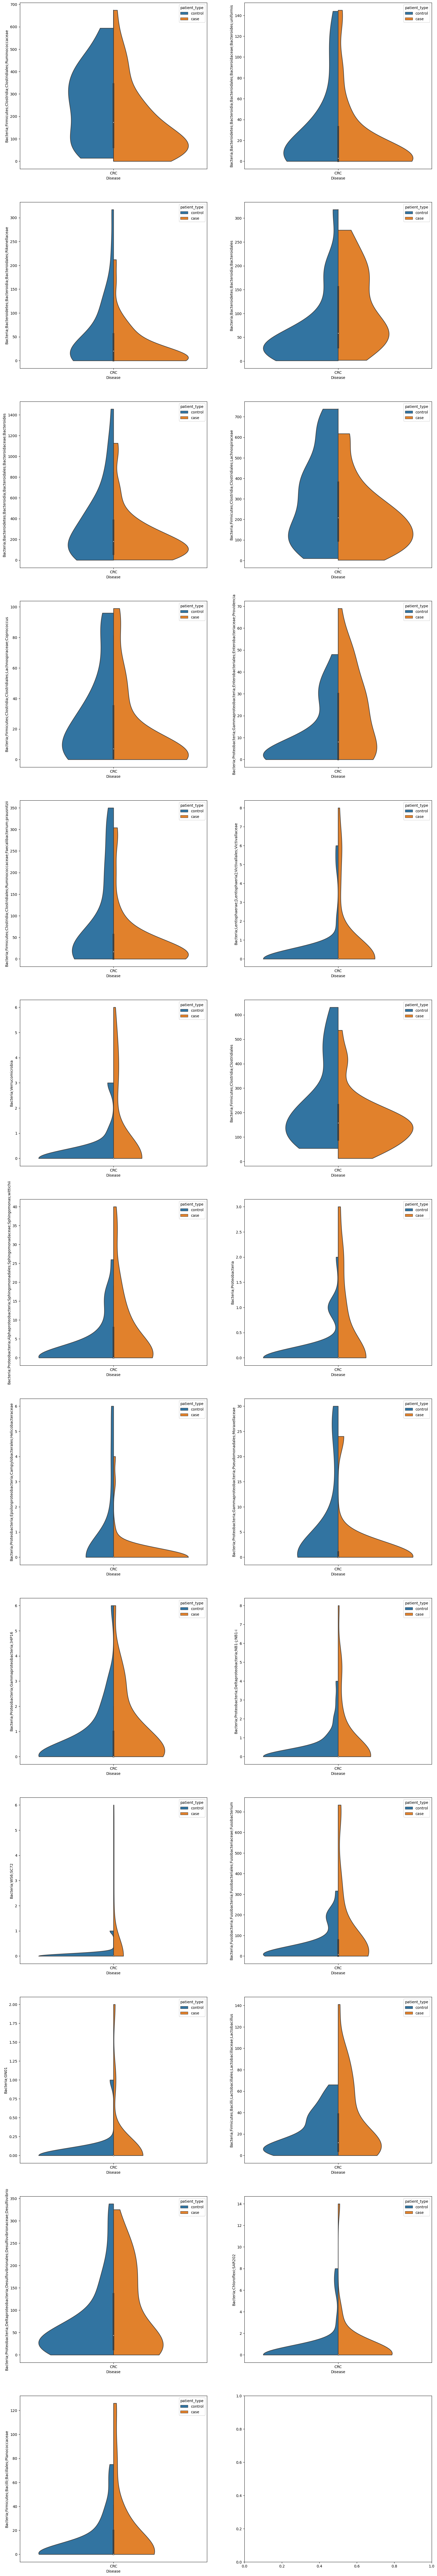

In [27]:
# For CRC

crc_bacteria_list = crc_interesting_bacteria['bacteria'].to_list()
crc_bacteria_index = crc_interesting_bacteria['index'].to_list()
size = (len(crc_bacteria_list)/2)*10
rows = math.ceil(len(crc_bacteria_list)/2)
fig, axes = plt.subplots(rows, 2, figsize=(20,size))

for index, (bacteria, i) in enumerate(zip(crc_bacteria_list, crc_bacteria_index)):
    crc_df = processDataframe(crc_bacteria, crc_metadata, bacteria, i, 'CRC')
    df = pd.concat([crc_df], axis=0)
    col = index%2;
    row = math.floor(index/2);
    sns.violinplot(y=bacteria,x='Disease',data=crc_df, hue='patient_type', split=True, cut=0, ax=axes[row][col])

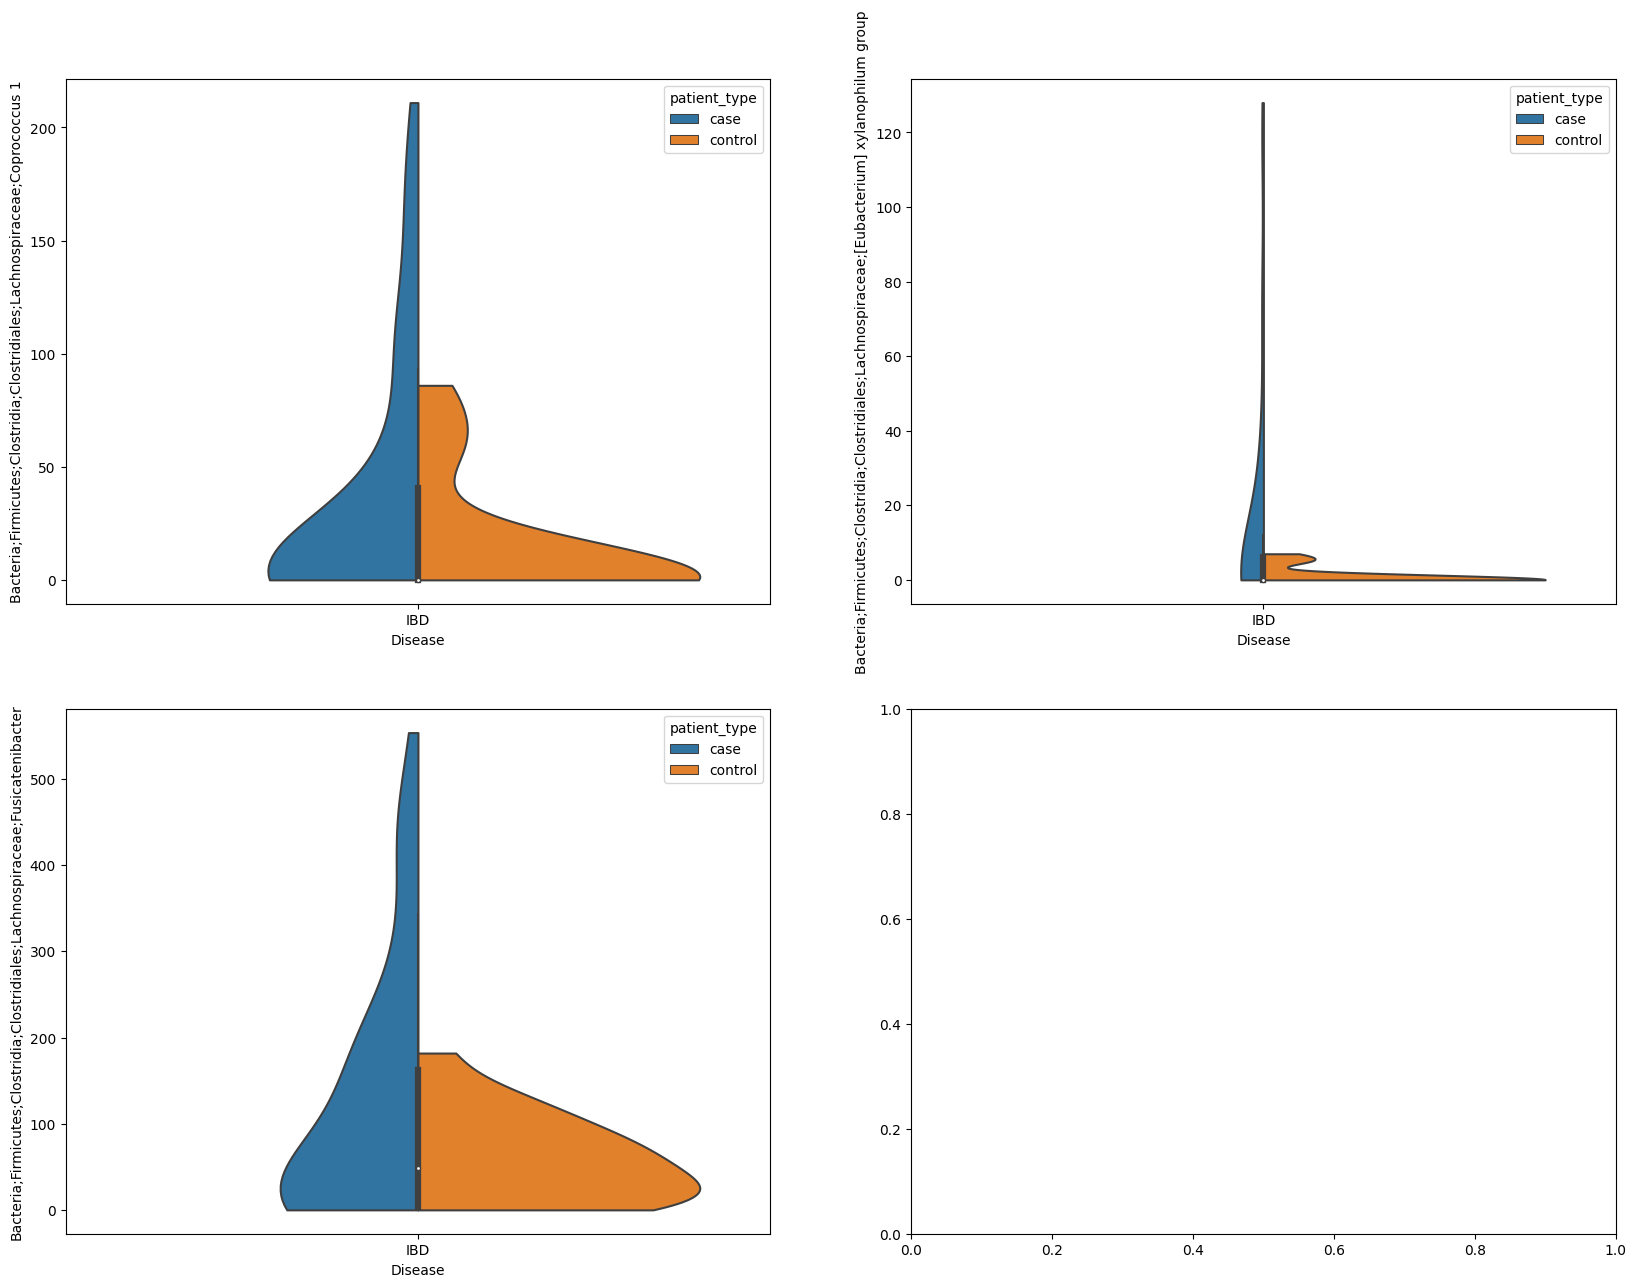

In [357]:
# For IBD

ibd_bacteria_list = ibd_interesting_bacteria['bacteria'].to_list()
ibd_bacteria_index = ibd_interesting_bacteria['index'].to_list()
size = (len(ibd_bacteria_list)/2)*10
rows = math.ceil(len(ibd_bacteria_list)/2)
fig, axes = plt.subplots(rows, 2, figsize=(20,size))

for index, (bacteria, i) in enumerate(zip(ibd_bacteria_list, ibd_bacteria_index)):
    ibd_df = processDataframe(ibd_bacteria, ibd_metadata, bacteria, i, 'IBD');
    df = pd.concat([ibd_df], axis=0)
    col = index%2;
    row = math.floor(index/2);
    sns.violinplot(y=bacteria,x='Disease',data=df, hue='patient_type', split=True, cut=0, ax=axes[row][col])